In [1]:
import os
import sys

project_dir = os.path.dirname(os.getcwd())
print(project_dir)
sys.path.append(project_dir)

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf

import torch
from torchvision.transforms import ToPILImage, ToTensor, Normalize
from training.dataset.transforms import ComposeAPI, NormalizeAPI
from tqdm import tqdm

from helpers.configurations import TRACK_TO_METAINFO
from dataset.collate_fn import collate_fn
from dataset.mini_dataset import MiniDataset
from debugging.show import *
from custom_model_builder import build_sam2_predict

/home/guests/tuna_gurbuz/prototype


In [2]:
# Dataset
object_labels = [10]
len_video = 1
input_image_size = 512
batch_size = 1
shuffle = False
mean = [0.3551, 0.3500, 0.3469]
std = [0.2921, 0.2716, 0.2742]
transforms = [ComposeAPI([NormalizeAPI(mean=mean, std=std, v2=True)])]
revert_mean=[-.3551/.2921, -.3500/.2716, -.3469/.2742]
revert_std=[1/.2921, 1/.2716, 1/.2742]
revert_transform = Normalize(mean=revert_mean, std=revert_std)
test_dataset = MiniDataset('val',
                           num_frames=len_video,
                           input_image_size=input_image_size,
                           object_labels=object_labels,
                           transforms=transforms,
                           collate_fn=collate_fn,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           get_seg_mask=True)
print(f'Lenght of the dataset! {len(test_dataset)}')

Loading the take 002_PKA!



0it [00:00, ?it/s]

4311it [00:02, 1662.42it/s]


Loading the take 007_TKA!



3466it [00:01, 1767.61it/s]


Loading the take 009_TKA!



3276it [00:02, 1336.86it/s]

Lenght of the dataset! 33159


In [3]:
seed = 123  # Check seed 123 index 19966
torch.manual_seed(seed)
np.random.seed(seed)

len_objects = len(object_labels)
toPILimage = ToPILImage()
# iid = 3333  # Check seed 123 index 19966
iid = 19968

In [4]:
# print(f'Length of the dataset: {len(test_dataset)}')

# # NEW SLICE
# print(test_dataset.images[0], '\n',test_dataset.images[1], '\n',test_dataset.images[2])

In [5]:
# Get the first three images
cam1 = test_dataset.images[iid]
cam4 = test_dataset.images[iid + 1]
cam5 = test_dataset.images[iid + 2]

print(f'Cam1: {cam1}, Cam4: {cam4}, Cam5: {cam5}')

# Use get item: 0) VideoDataBatch 1) Segmentation mask
cam1_vid = test_dataset[iid]
cam4_vid = test_dataset[iid + 1]
cam5_vid = test_dataset[iid + 2]

# Use first frame
cam1 = cam1_vid.frames[0].data
cam4 = cam4_vid.frames[0].data
cam5 = cam5_vid.frames[0].data

gt_mask1 = cam1_vid.frames[0].objects[0].segment
gt_mask4 = cam4_vid.frames[0].objects[0].segment
gt_mask5 = cam5_vid.frames[0].objects[0].segment

print(gt_mask1.shape)
print(gt_mask1.dtype)

Cam1: [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/007_TKA/colorimage/camera01_colorimage-002541.jpg')], Cam4: [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/007_TKA/colorimage/camera04_colorimage-002541.jpg')], Cam5: [PosixPath('/home/polyaxon-data/data1/MM-OR_processed/007_TKA/colorimage/camera05_colorimage-002541.jpg')]
torch.Size([512, 512])
torch.uint8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


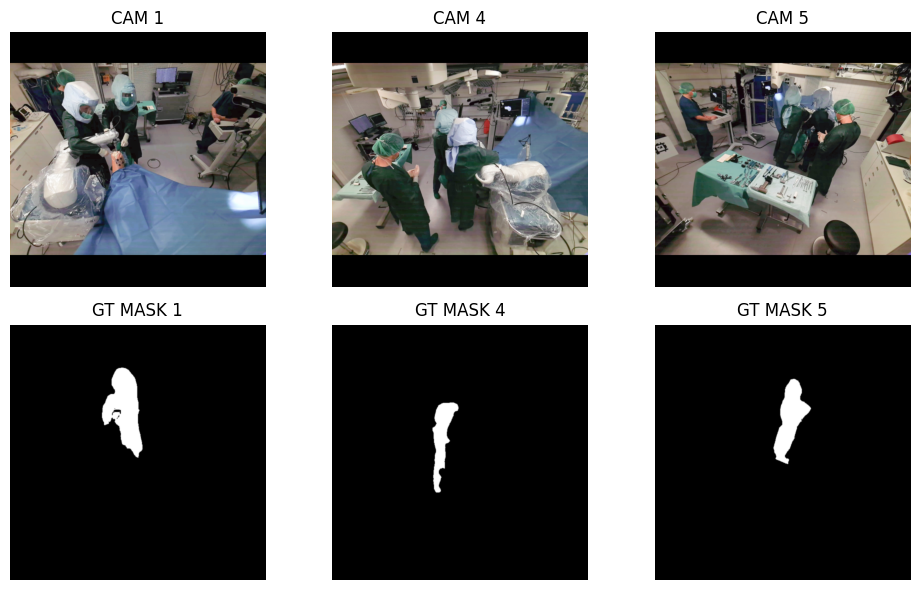

In [6]:
# Create figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Transpose from tensor to numpy shape
cam1 = revert_transform(cam1).permute(1,2,0)
cam4 = revert_transform(cam4).permute(1,2,0)
cam5 = revert_transform(cam5).permute(1,2,0)

# First row (RGB, GT, Black Placeholder)
axes[0,0].imshow(cam1)
axes[0,0].set_title("CAM 1")

axes[0,1].imshow(cam4)
axes[0,1].set_title("CAM 4")

axes[0,2].imshow(cam5)
axes[0,2].set_title("CAM 5")

axes[1,0].imshow(gt_mask1, cmap='gray')
axes[1,0].set_title("GT MASK 1")

axes[1,1].imshow(gt_mask4, cmap='gray')
axes[1,1].set_title("GT MASK 4")

axes[1,2].imshow(gt_mask5, cmap='gray')
axes[1,2].set_title("GT MASK 5")

# Remove axes for a cleaner look
for ax in axes.ravel():
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
# is_black_row = (cam1[:,:,0] <= 0)  # Check along width and channels
# pos_padding = np.where(is_black_row == False)
# start = pos_padding[0][0]
# end = pos_padding[0][-1]

# # Slice the predictions and ground truth masks
# if start == 64:
#     cam1 = cam1[start:end+1, :, :]
#     cam4 = cam4[start:end+1, :, :]
#     cam5 = cam5[start:end+1, :, :]
# elif start == 0:
#     pass
# else:
#     raise ValueError("Padding not found in the image")
start = 0

In [8]:
import os
import json

import cv2
import numpy as np
from scipy.spatial.transform import Rotation

def skew(t):
    return np.array([
        [0, -t[2], t[1]],
        [t[2], 0, -t[0]],
        [-t[1], t[0], 0]
    ])

In [9]:
def compute_epipolar_lines(ext, K_line, K_pt, pts1):
    # pts1: Nx2 array
    R, t = ext[:3, :3], ext[:3, 3]
    E = skew(t) @ R
    inv_K1 = np.linalg.inv(K_line)
    inv_K0 = np.linalg.inv(K_pt)
    F = inv_K0.T @ E @ inv_K1
    pts1_h = np.hstack((pts1, np.ones((pts1.shape[0], 1))))  # homogeneous
    lines2 = (F @ pts1_h.T).T  # Each row is [a, b, c]
    return lines2

def draw_epilines(img2, lines, colors, padding=0):
    h, w = img2.shape[:2]
    for r, color in zip(lines, colors):
        color = color.tolist() if isinstance(color, np.ndarray) else color
        # a, b, c = r
        # x0, x1 = 0, w
        # y0 = int((-c - a * x0) / b)
        # y1 = int((-c - a * x1) / b)
        x0,y0 = map(int, [0, -(r[2])/r[1] - padding])
        x1,y1 = map(int, [w, -(r[2] + r[0]*w)/r[1] - padding])
        img2 = cv2.line(img2, (x0, y0), (x1, y1), color, 2)
    return img2

In [10]:
def load_camera_data(camera_data, downscale=1):
    h, w = camera_data['value0']['color_parameters']['height'], camera_data['value0']['color_parameters']['width']
    h_, w_ = h // downscale, w // downscale
    padding = (w_ - h_) // 2
    # padding = 0
    intrinsics_json = camera_data['value0']['color_parameters']['intrinsics_matrix']
    K = np.asarray([[intrinsics_json['m00'] / downscale, intrinsics_json['m10'], intrinsics_json['m20'] / downscale],
                    [intrinsics_json['m01'], intrinsics_json['m11'] / downscale, intrinsics_json['m21'] / downscale + padding],
                    [0, 0, 1]])
    # Extrinsics Depth
    extrinsics_json = camera_data['value0']['camera_pose']
    trans = extrinsics_json['translation']
    rot = extrinsics_json['rotation']
    extrinsics = np.zeros((4, 4), dtype=np.float32)
    R = Rotation.from_quat([rot['x'], rot['y'], rot['z'], rot['w']]).as_matrix()
    extrinsics[:3, :3] = R
    t = [trans['m00'], trans['m10'], trans['m20'], 1]
    extrinsics[:, 3] = t

    # Extrinsics Color
    color2depth_json = camera_data['value0']['color2depth_transform']
    trans = color2depth_json['translation']
    rot = color2depth_json['rotation']
    color2depth_transform = np.zeros((4, 4), dtype=np.float32)
    rot_matrix = Rotation.from_quat([rot['x'], rot['y'], rot['z'], rot['w']]).as_matrix()
    color2depth_transform[:3, :3] = rot_matrix
    color2depth_transform[:, 3] = [trans['m00'], trans['m10'], trans['m20'], 1]
    depth_extrinsics = np.copy(extrinsics)
    extrinsics = extrinsics @ color2depth_transform  # Extrinsics were given for the depth camera, convert them to color camera
    extrinsics = extrinsics @ np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]], dtype=np.float32)

    # Distortion
    rad_dist = camera_data['value0']['color_parameters']['radial_distortion']
    tan_dist = camera_data['value0']['color_parameters']['tangential_distortion']
    dist = [rad_dist.pop('m00'), rad_dist.pop('m10'), tan_dist.pop('m00'), tan_dist.pop('m10')]
    dist += [rd for rd in rad_dist.values()]
    dist = np.array(dist, dtype=np.float32)

    return K, extrinsics, padding, dist, depth_extrinsics

In [11]:
file_name = test_dataset.images[iid][0]  # Get the file name from the dataset, list to string
print(f'File name: {file_name}')
take_path = file_name.parent.parent
# take_path = '/home/polyaxon-data/data1/MM-OR_processed/001_PKA/'
downscale = 4
camera_files = ['camera01.json', 'camera04.json', 'camera05.json']
camera_int_ext = []
for json_file in camera_files:
    with open(os.path.join(take_path, json_file), 'r') as f:
        camera_data = json.load(f)
    intr, ext, padding, dist, depth_ext = load_camera_data(camera_data, downscale)
    camera_int_ext.append((intr, ext, dist, depth_ext))

File name: /home/polyaxon-data/data1/MM-OR_processed/007_TKA/colorimage/camera01_colorimage-002541.jpg


In [ ]:
# import json
# json_data = {i: [cam[0].tolist(), cam[1].tolist()] for i, cam in enumerate(camera_int_ext)}
# with open('../camera_int_ext.json', 'w') as f:
#     json.dump(json_data, f)

In [13]:
K0, ext0, dist0, depth_ext0 = camera_int_ext[0]
K1, ext1, dist1, depth_ext1 = camera_int_ext[1]
K2, ext2, dist2, depth_ext2 = camera_int_ext[2]

In [14]:
def compute_inverse(ext):
    inv = np.zeros((4, 4), dtype=np.float32)
    inv[:3, :3] = ext[:3,:3].T
    inv[:3, 3] = -ext[:3,:3].T @ ext[:3, 3]
    return inv

In [15]:
# Compute relative transforms
inv0 = compute_inverse(ext0)
inv1 = compute_inverse(ext1)
inv2 = compute_inverse(ext2)

ext_1_to_0 = inv0 @ ext1
ext_2_to_0 = inv0 @ ext2

ext_0_to_1 = inv1 @ ext0
ext_2_to_1 = inv1 @ ext2

ext_0_to_2 = inv2 @ ext0
ext_1_to_2 = inv2 @ ext1

In [16]:
num_points_idx = 20
# Define points in image 4
y, x = torch.where(gt_mask1 == 255)
y -= start  # We remove the padding should lift the mask
pts_cam1 = torch.cat([x.unsqueeze(1), y.unsqueeze(1)], dim=1).numpy()[0:num_points_idx]

# Define points in image 4
y, x = torch.where(gt_mask4 == 255)
y -= start  # We remove the padding should lift the mask
pts_cam4 = torch.cat([x.unsqueeze(1), y.unsqueeze(1)], dim=1).numpy()[0:num_points_idx]

# Define Points in Image 5
y, x = torch.where(gt_mask5 == 255)
y -= start  # We remove the padding should lift the mask
pts_cam5 = torch.cat([x.unsqueeze(1), y.unsqueeze(1)], dim=1).numpy()[0:num_points_idx]

In [17]:
# Compute epipolar lines
epi_lines_4_to_1 = compute_epipolar_lines(ext_1_to_0, K0, K1, pts_cam4)
epi_lines_5_to_1 = compute_epipolar_lines(ext_2_to_0, K0, K2, pts_cam5)

epi_lines_1_to_4 = compute_epipolar_lines(ext_0_to_1, K1, K0, pts_cam1)
epi_lines_5_to_4 = compute_epipolar_lines(ext_2_to_1, K1, K2, pts_cam5)

epi_lines_1_to_5 = compute_epipolar_lines(ext_0_to_2, K2, K0, pts_cam1)
epi_lines_4_to_5 = compute_epipolar_lines(ext_1_to_2, K2, K1, pts_cam4)

Project Cam 4 Points on Cam 1

In [18]:
# Define colors for points
num_points = pts_cam4.shape[0]
colors4 = plt.cm.jet(np.linspace(0, 1, num_points))[:, :] * 255  # RGB 0-255
colors4 = colors4.astype(np.uint8)
cam1_draw = cam1.numpy().copy()

# Draw Epipolar Lines
cam1_draw = draw_epilines(cam1_draw, epi_lines_4_to_1, colors4, padding=0)

Project Cam 5 Points on Cam 1

In [19]:
# Define colors for points
num_points = pts_cam5.shape[0]
colors5 = plt.cm.jet(np.linspace(0, 1, num_points))[:, :] * 255  # RGB 0-255
colors5 = colors5.astype(np.uint8)

# Draw Epipolar Lines
cam1_draw = draw_epilines(cam1_draw, epi_lines_5_to_1, colors5, padding=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


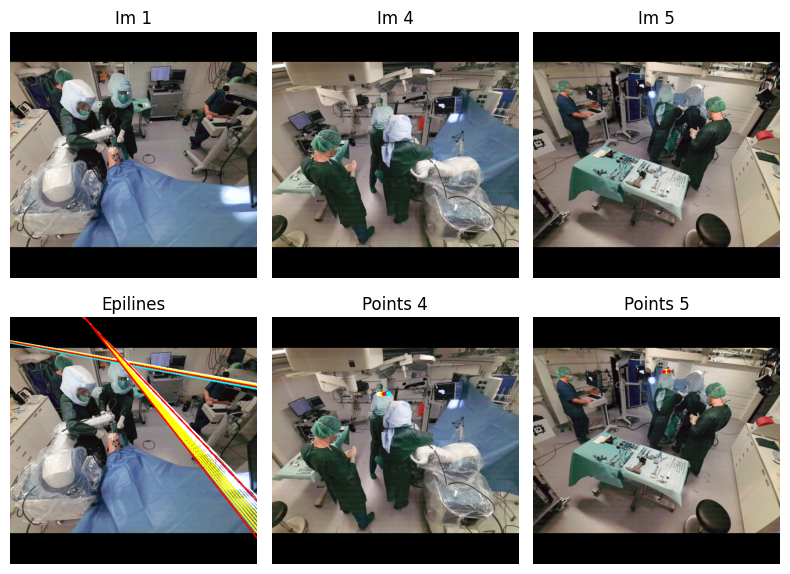

In [20]:
img4_color = cam4.numpy().copy()
for pt, color in zip(pts_cam4, colors4):
    pt_int = tuple(np.round(pt).astype(int))
    img4_color = cv2.circle(img4_color, pt_int, 4, color.tolist(), -1)

img5_color = cam5.numpy().copy()
for pt, color in zip(pts_cam5, colors5):
    pt_int = tuple(np.round(pt).astype(int))
    img5_color = cv2.circle(img5_color, pt_int, 4, color.tolist(), -1)
    
figsize = np.array([8,6])
fig, axs = plt.subplots(2, 3, figsize=figsize, )

axs[0,0].imshow(cam1.numpy().copy())
axs[0,0].axis('off')
axs[0,0].set_title("Im 1")

axs[0,1].imshow(cam4.numpy().copy())
axs[0,1].axis('off')
axs[0,1].set_title("Im 4")

axs[0,2].imshow(cam5.numpy().copy())
axs[0,2].axis('off')
axs[0,2].set_title("Im 5")

axs[1,0].imshow(cam1_draw)
axs[1,0].axis('off')
axs[1,0].set_title("Epilines")

axs[1,1].imshow(img4_color)
axs[1,1].axis('off')
axs[1,1].set_title("Points 4")

axs[1,2].imshow(img5_color)
axs[1,2].axis('off')
axs[1,2].set_title("Points 5")

plt.tight_layout()
plt.show()

In [21]:
skip = 1  # Skip every 10th point for visualization
a, b, c = epi_lines_4_to_1.T[:, ::skip]
a, b, c = a[:, None], b[:, None], c[:, None]
k, l, m = epi_lines_5_to_1.T[:, ::skip]
k, l, m = k[:, None], l[:, None], m[:, None]

def intersection(a, b, c, k, l, m):
    x = (-c * l + m * b) / (a * l - k * b)
    y = (-c - a * x) / b
    return np.concatenate((x, y), axis=1)

# Calculate the intersection point
for i in range(len(a)):
    if i == 0:
        intersect_point = intersection(a[0:1], b[0:1], c[0:1], k, l, m)
    else:
        curr_point = intersection(a[i:i+1], b[i:i+1], c[i:i+1], k, l, m)
        intersect_point = np.concatenate((intersect_point, curr_point), axis=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


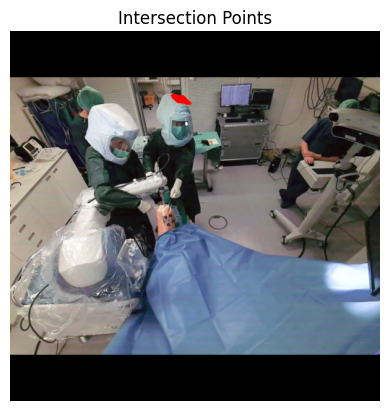

In [22]:
img1_color = cam1.numpy().copy()
for pt in intersect_point:
    pt_int = tuple(np.round(pt).astype(int))
    img1_color = cv2.circle(img1_color, pt_int, 2, [255, 0, 0], 1)

plt.imshow(img1_color)
plt.axis('off')
plt.title("Intersection Points")
plt.show()